In [47]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython import get_ipython
from numpy.linalg import svd
from util import nextplot, plot_xy
from sklearn.cluster import KMeans
from numpy.linalg import svd

# setup plotting
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
inJupyterLab = any(filter(lambda x: x.endswith("jupyter-lab"), psutil.Process().parent().cmdline()))
if not inJupyterLab:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")

# 1 Probabilistic PCA

## 1a) Toy data

In [48]:
# You do not need to modify this method.
def ppca_gen(N=10000, D=2, L=2, sigma2=0.5, mu=None, lambda_=None, Q=None, seed=None):
    """Generate data from a given PPCA model.

    Unless specified otherwise, uses a fixed mean, fixed eigenvalues (variances along
    principal components), and a random orthogonal eigenvectors (principal components).

    """

    # determine model parameters (from arguments or default)
    rng = np.random.RandomState(seed)
    if mu is None:
        mu = np.arange(D) + 1.0
    if Q is None:
        Q = scipy.stats.ortho_group.rvs(D, random_state=rng)
    if lambda_ is None:
        lambda_ = np.arange(D, 0, -1) * 2

    # weight matrix is determined from first L eigenvectors and eigenvalues of
    # covariance matrix
    Q_L = Q[:, :L]
    lambda_L = lambda_[:L]
    W = Q_L * np.sqrt(lambda_L)  # scales columns

    # generate data
    Z = rng.standard_normal(size=(N, L))  # latent variables
    Eps = rng.standard_normal(size=(N, D)) * np.sqrt(sigma2)  # noise
    X = Z @ W.transpose() + mu + Eps  # data points

    # all done
    return dict(
        N=N, D=D, L=L, X=X, Z=Z, mu=mu, Q_L=Q_L, lambda_L=lambda_L, W=W, Eps=Eps
    )

In [49]:
# You do not need to modify this method.
def ppca_plot_2d(data, X="X", mu="mu", W="W", alpha=0.05, axis=None, **kwargs):
    """Plot 2D PPCA data along with its weight vectors."""
    if not axis:
        nextplot()
        axis = plt.gca()
    X = data[X] if isinstance(X, str) else X
    plot_xy(X[:, 0], X[:, 1], alpha=alpha, axis=axis, **kwargs)

    # additional plot elements: mean and components
    if mu is not None:
        mu = data[mu] if isinstance(mu, str) else mu
        if W is not None:
            W = data[W] if isinstance(W, str) else W
            head_width = np.linalg.norm(W[:, 0]) / 10.0
            for j in range(W.shape[1]):
                axis.arrow(
                    mu[0],
                    mu[1],
                    W[0, j],
                    W[1, j],
                    length_includes_head=True,
                    head_width=head_width,
                )

273244.3990646409


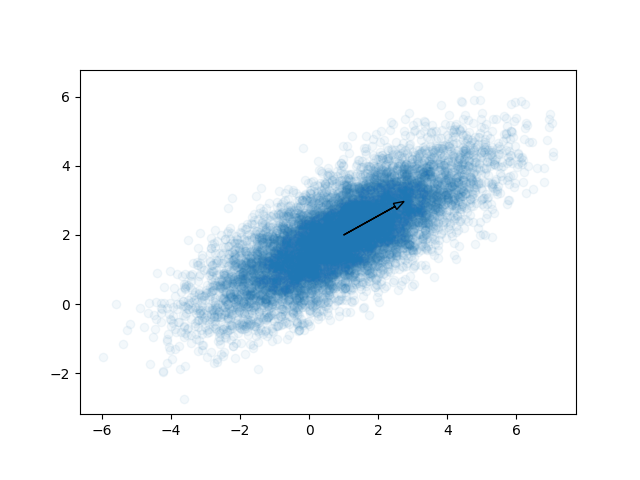

In [50]:
# Generate and plot a toy dataset
toy_ppca = ppca_gen(L=1, sigma2=0.5, seed=0)
ppca_plot_2d(toy_ppca)
print(np.sum(toy_ppca["X"] ** 3))  # must be 273244.3990646409

/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_91433/1981961334.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0, 0])


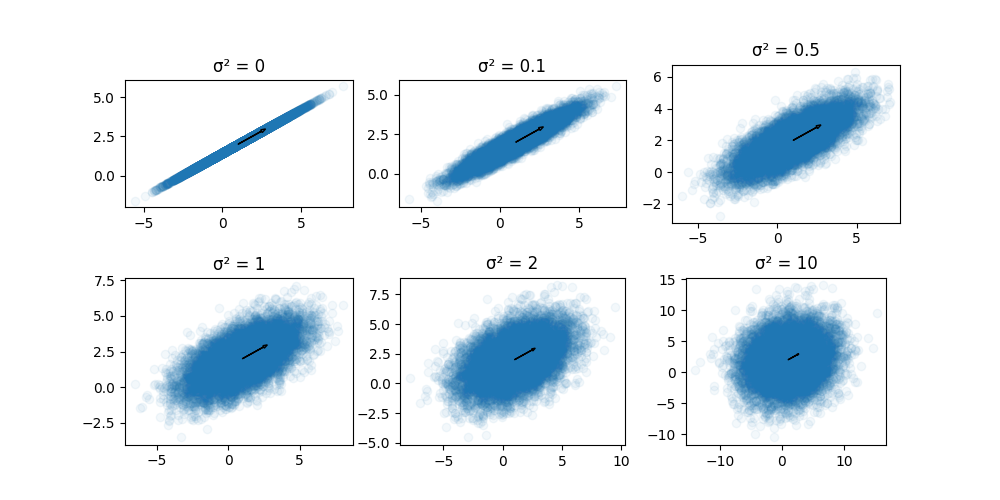

In [51]:
# Impact of noise
# we set a range of noise values from 0 to 10
noise_values = [0, 0.1, 0.5, 1, 2, 10]

# and plot them in one figure to be able to compare them conveniently
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.flatten()

for i in range(6):
    toy_ppca_s = ppca_gen(L=1, sigma2=noise_values[i], seed=0)
    ppca_plot_2d(toy_ppca_s, axis=axs[i])
    axs[i].set_title(f'σ² = {noise_values[i]}')  


# adjusting alignment to use more space
plt.tight_layout(rect=[0, 0, 0, 0]) 
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust space between subplots

plt.show()

## 1b) Maximum Likelihood Estimation

In [52]:
def ppca_mle(X, L):
    """Computes the ML estimates of PPCA model parameters.

    Returns a dictionary with keys `mu`, `W`, and `sigma2` and the corresponding ML
    estimates as values.

    """
    N, D = X.shape

    # Compute the ML estimates of the PPCA model parameters: mu_mle, sigma2_mle (based
    # on mu_mle), and W_mle (based on mu_mle and sigma2_mle). In your code, only use
    # standard matrix/vector operations and svd(...).
    mu_mle = np.mean(X, axis=0)
    M = X - mu_mle
    U, s, Vt = np.linalg.svd(M)
    S = np.diag(s)
    # to avoid division by zero (D-L) in denominator when averaging the discarded eigenvalues, 
    # we directly set sigma hat squared_MLE to zero, since there are no components discarded
    if L == D:
        sigma2_mle = 0
    else:
        sigma2_mle = np.sum((s**2)[L:])/(N*(D-L))
    
    W_mle = np.matmul(Vt[:L].T,((S**2)[:L,:L]/N - sigma2_mle*np.identity(L))**0.5)


    return dict(mu=mu_mle, W=W_mle, sigma2=sigma2_mle)

In [53]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
#  'W': array([[-1.72988776], [-0.95974566]]),
#  'sigma2': 0.4838656103694303}
ppca_mle(toy_ppca["X"], 1)

{'mu': array([0.96935329, 1.98309575]),
 'W': array([[-1.72988776],
        [-0.95974566]]),
 'sigma2': 0.4838656103694313}

In [54]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
 # 'W': array([[-1.83371058,  0.33746522], [-1.0173468 , -0.60826214]]),
 # 'sigma2': 0.0}
ppca_mle(toy_ppca["X"], 2)

{'mu': array([0.96935329, 1.98309575]),
 'W': array([[-1.83371058,  0.33746522],
        [-1.0173468 , -0.60826214]]),
 'sigma2': 0}

## 1c) Negative Log-Likelihood

The log likelihood for PPCA is given by

$$
\log p(\mathbf{X} \mid \boldsymbol{\mu}, \mathbf{W}, \sigma^2) = 
-\frac{ND}{2} \log(2\pi) - \frac{N}{2} \log|\mathbf{C}| 
- \frac{1}{2} \sum_{n=1}^{N} (\mathbf{x}_n - \boldsymbol{\mu})^\top \mathbf{C}^{-1} (\mathbf{x}_n - \boldsymbol{\mu})
$$

where
$$ 
\mathbf{C} = \mathbf{W}\mathbf{W}^{-1} +\sigma^2 \mathbf{I}
$$



(formula 20.43 from K.P.Murphy. Probabilistic Machine Learning: An introduction. MIT Press, 2022)

In [55]:
def ppca_nll(X, model):
    """Compute the negative log-likelihood for the given data.

    Model is a dictionary containing keys "mu", "sigma2" and "W" (as produced by
    `ppca_mle` above).

    """
    N, D = X.shape
    
    # getting model elements
    mu = model['mu']
    W = model['W']
    sigma2 = model['sigma2']

    # we will use the formula of the log-likelihood for PPCA with the flipped signs (sum instead of difference)
    
    # calculating C and inverse
    C = np.matmul(W, W.T) + sigma2*np.identity(D)
    C1 = np.linalg.inv(C)
    
    # calculating third part of the sum
    X2 = X - mu
    Y = 0
    for i in range(N):
        Y += np.matmul(np.matmul(X2[i].T,C1),X2[i])
    
    # inserting elements in the main formula
    output = (N*D/2)*np.log(2*np.pi) + (N/2)*np.log(np.linalg.det(C)) + Y/2
    
    return output

In [56]:
# Test your solution. This should produce: 32154.198760474777
ppca_nll(toy_ppca["X"], ppca_mle(toy_ppca["X"], 1))

32154.19876047481

## 1d) Discover the Secret!

In [57]:
# Load the secret data
X = np.loadtxt("data/secret_ppca.csv", delimiter=",")

/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_91433/14219614.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))


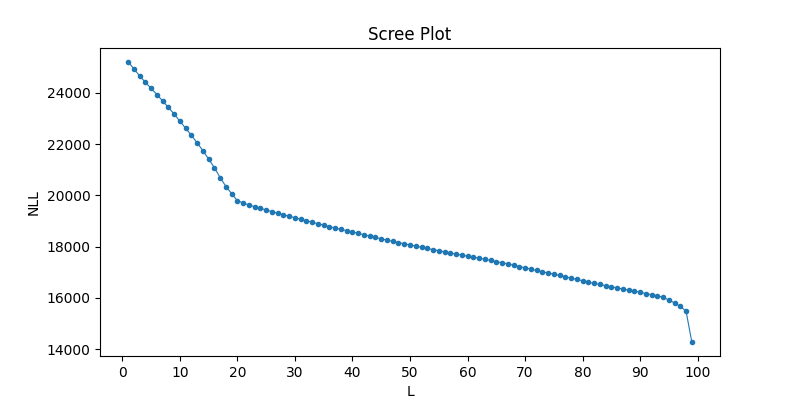

In [58]:
# Scree plot for choice of L
nll = []

# take L values up until the number of features of X
for i in range(1, X.shape[1]):
    nll.append(ppca_nll(X, ppca_mle(X, i)))

# plot the negative log-likelihood for each L
plt.figure(figsize=(8, 4))
x = np.arange(1, len(nll)+1)
plt.plot(x, nll, marker='.', linestyle='-', linewidth = 0.8)
plt.title('Scree Plot')
plt.xlabel('L')
xticks = np.arange(0, X.shape[1]+1, 10)
plt.xticks(xticks)
plt.ylabel('NLL')
plt.show()
# the optimal choice seems to be at L=21

In [59]:
# Determine a suitable choice of L using validation data.
split = len(X) * 3 // 4
X_train = X[:split,]
X_valid = X[split:,]

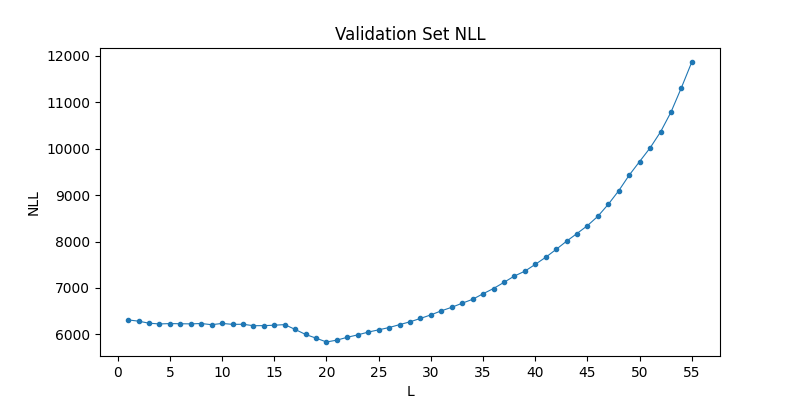

In [60]:
# Validation data for choice of L
nll = []

for i in range(1, 56):
    nll.append(ppca_nll(X_valid, ppca_mle(X_train, i)))

# plot the negative log-likelihood for each L
plt.figure(figsize=(8, 4))
x = np.arange(1, len(nll)+1)
plt.plot(x, nll, marker='.', linestyle='-', linewidth = 0.8)
plt.title('Validation Set NLL')
plt.xlabel('L')
xticks = np.arange(0, len(nll)+1, 5)
plt.xticks(xticks)
plt.ylabel('NLL')
plt.show()


# 2 Gaussian Mixture Models

## 2a) Toy data

In [61]:
# You do not need to modify this function.
def gmm_gen(N, mu, pi, Sigma=None, seed=None):
    """Generate data from a given GMM model.

    `N` is the number of data points to generate. `mu` and `Sigma` are lists with `K`
    elements holding the mean and covariance matrix of each mixture component. `pi` is a
    `K`-dimensional probability vector of component sizes.

    If `Sigma` is unspecified, a default (random) choice is taken.
    """
    K = len(pi)
    D = len(mu[0])
    rng = np.random.RandomState(seed)
    if Sigma is None:
        Sigma = [
            Q.transpose() @ np.diag([(k + 1) ** 2, k + 1]) @ Q
            for k, Q in enumerate([scipy.stats.ortho_group.rvs(2, random_state=rng) for k in range(K)])
        ]

    components = rng.choice(range(K), p=pi, size=N)
    X = np.zeros([N, D])
    for k in range(K):
        indexes = components == k
        N_k = np.sum(indexes.astype(np.int_))
        if N_k == 0:
            continue

        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k], seed=rng)
        X[indexes, :] = dist.rvs(size=N_k)

    return dict(X=X, components=components, mu=mu, Sigma=Sigma, pi=pi)

-4380876.753061278


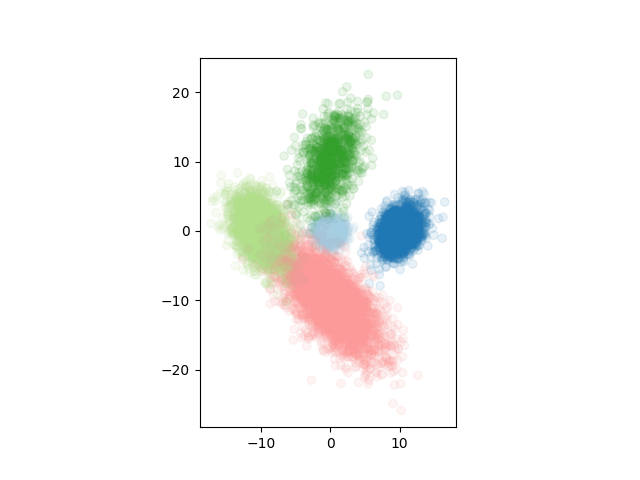

In [62]:
# Generate a toy dataset and plot it.
toy_gmm = gmm_gen(
    10000,
    [
        np.array([0, 0]),
        np.array([10, 0]),
        np.array([-10, 0]),
        np.array([0, 10]),
        np.array([0, -10]),
    ],
    np.array([0.1, 0.2, 0.25, 0.1, 0.35]),
    seed=4,
)

print(np.sum(toy_gmm["X"] ** 3))  # must be -4380876.753061278

plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], toy_gmm["components"], alpha=0.1)

## 2b) K-Means

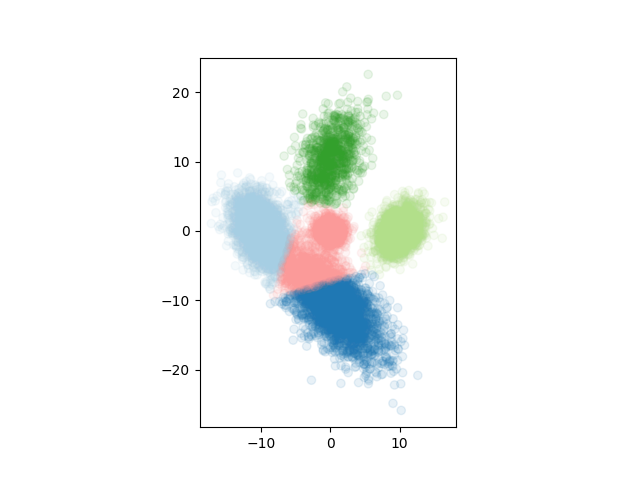

In [63]:
# Fit 5 clusters using k-means.
kmeans = KMeans(5).fit(toy_gmm["X"])
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

## 2c) Fit a GMM

In [64]:
import numpy as np
from scipy.stats import multivariate_normal

def gmm_e(X, model, return_F=False):
    """Perform the E step of EM for a GMM (MLE estimate).

    `model` is a dictionary holding model parameters (keys `mu`, `Sigma`, and `pi`
    defined as in `gmm_gen`).

    Returns a NxK matrix of cluster membership probabilities. If `return_F` is true,
    also returns an NxK matrix holding the density of each data point (row) for each
    component (column).
    """
    mu, Sigma, pi = model["mu"], model["Sigma"], model["pi"]
    N, D = X.shape
    K = len(pi)
    
    # Initialize NxK matrices
    F = np.zeros((N, K)) 
    W = np.zeros((N, K)) 
    
    # Compute the density for each cluster and data point
    for k in range(K):
        # Multivariate normal density
        dist = multivariate_normal(mean=mu[k], cov=Sigma[k])
        F[:, k] = dist.pdf(X)  # Likelihood for cluster k
    
    # Compute responsibilities (W) using mixing coefficients
    numerator = F * pi
    denominator = np.sum(numerator, axis=1, keepdims=True) 
    W = numerator / denominator 
    
    # Return responsibilities (W) and optionally densities (F)
    if return_F:
        return W, F
    else:
        return W


In [65]:
# Test your solution. This should produce:
# (array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41, 2.78010004e-65],
        # [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34, 1.86750812e-46],
        # [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09, 1.62736835e-10]]),
 # array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50, 1.59217812e-73],
        # [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50, 8.97398547e-62],
        # [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18, 1.00413265e-19]]))
dummy_model = dict(
    mu=[np.array([k, k + 1]) for k in range(5)],
    Sigma=[np.array([[3, 1], [1, 2]]) / (k + 1) for k in range(5)],
    pi=np.array([0.1, 0.25, 0.15, 0.2, 0.3]),
)
gmm_e(toy_gmm["X"][:3,], dummy_model, return_F=True)

(array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41,
         2.78010004e-65],
        [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34,
         1.86750812e-46],
        [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09,
         1.62736835e-10]]),
 array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50,
         1.59217812e-73],
        [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50,
         8.97398547e-62],
        [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18,
         1.00413265e-19]]))

In [66]:
import numpy as np

def gmm_m(X, W):
    """Perform the M step of EM for a GMM (MLE estimate).

    `W` is the NxK cluster membership matrix computed in the E step. Returns a new model
    (dictionary with keys `mu`, `Sigma`, and `pi` defined as in `gmm_gen`).
    """
    N, D = X.shape
    K = W.shape[1]

    mu = np.zeros((K, D))      
    Sigma = []            
    pi = np.zeros(K) 

    # Compute mixing coefficients
    Nk = np.sum(W, axis=0) 
    pi = Nk / N            

    # Compute means
    mu = (W.T @ X) / Nk[:, np.newaxis]  # Weighted mean for each cluster

 
    for k in range(K):
        X_centered = X - mu[k] 
        weighted_cov = (W[:, k][:, np.newaxis] * X_centered).T @ X_centered
        Sigma_k = weighted_cov / Nk[k]
        Sigma.append(Sigma_k)

    Sigma = np.array(Sigma)

    # Return updated model
    return dict(mu=mu, Sigma=Sigma, pi=pi)


In [67]:
# Test your solution. This should produce:
# {'mu': [array([ 6.70641574, -0.47971125]),
#   array([8.2353509 , 2.52134815]),
#   array([-3.0476848 , -1.70722161])],
#  'Sigma': [array([[88.09488652, 11.08635139],
#          [11.08635139,  1.39516823]]),
#   array([[45.82761873, 11.38773232],
#          [11.38773232,  6.87352224]]),
#   array([[98.6662729 , 12.41671355],
#          [12.41671355,  1.56258842]])],
#  'pi': array([0.13333333, 0.53333333, 0.33333333])}
gmm_m(toy_gmm["X"][:3,], np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.0, 1.0, 0.0]]))

{'mu': array([[ 6.70641574, -0.47971125],
        [ 8.2353509 ,  2.52134815],
        [-3.0476848 , -1.70722161]]),
 'Sigma': array([[[88.09488652, 11.08635139],
         [11.08635139,  1.39516823]],
 
        [[45.82761873, 11.38773232],
         [11.38773232,  6.87352224]],
 
        [[98.6662729 , 12.41671355],
         [12.41671355,  1.56258842]]]),
 'pi': array([0.13333333, 0.53333333, 0.33333333])}

In [68]:
# you do not need to modify this method
def gmm_fit(X, K, max_iter=100, mu0=None, Sigma0=None, pi0=None, gmm_m=gmm_m):
    """Fit a GMM model using EM.

    `K` refers to the number of mixture components to fit. `mu0`, `Sigma0`, and `pi0`
    are initial parameters (automatically set when unspecified).

    """
    N, D = X.shape

    if mu0 is None:
        mu0 = [np.random.randn(D) for k in range(K)]
    if Sigma0 is None:
        Sigma0 = [np.eye(D) * 10 for k in range(K)]
    if pi0 is None:
        pi0 = np.ones(K) / K

    model = dict(mu=mu0, Sigma=Sigma0, pi=pi0)
    for it in range(max_iter):
        W = gmm_e(X, model)
        model = gmm_m(X, W)

    return model

## 2d) K=5. Experiment with GMMs for the toy data

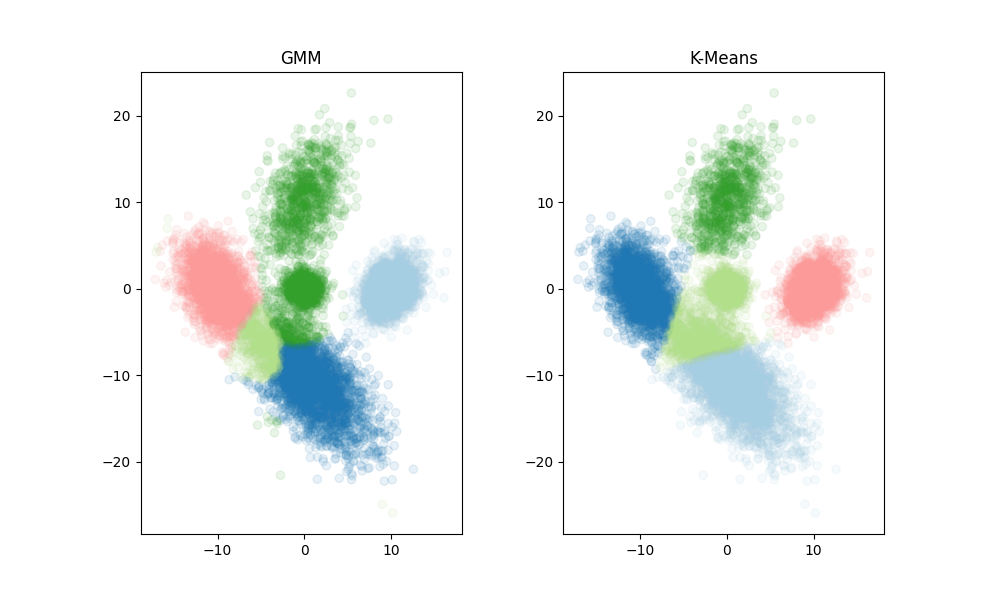

In [69]:
# GMM
toy_gmm_fit = gmm_fit(toy_gmm["X"], 5)

W = gmm_e(toy_gmm["X"], toy_gmm_fit)
cluster_labels = np.argmax(W, axis=1) # Most likely component for each point

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].set_title('GMM')
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], cluster_labels, alpha=0.1, axis=axes[0])

# Kmeans
kmeans = KMeans(5).fit(toy_gmm["X"])
axes[1].set_title('K-Means')
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1, axis=axes[1])

plt.show()

## 2e) K=4,6. Experiment with GMMs for the toy data

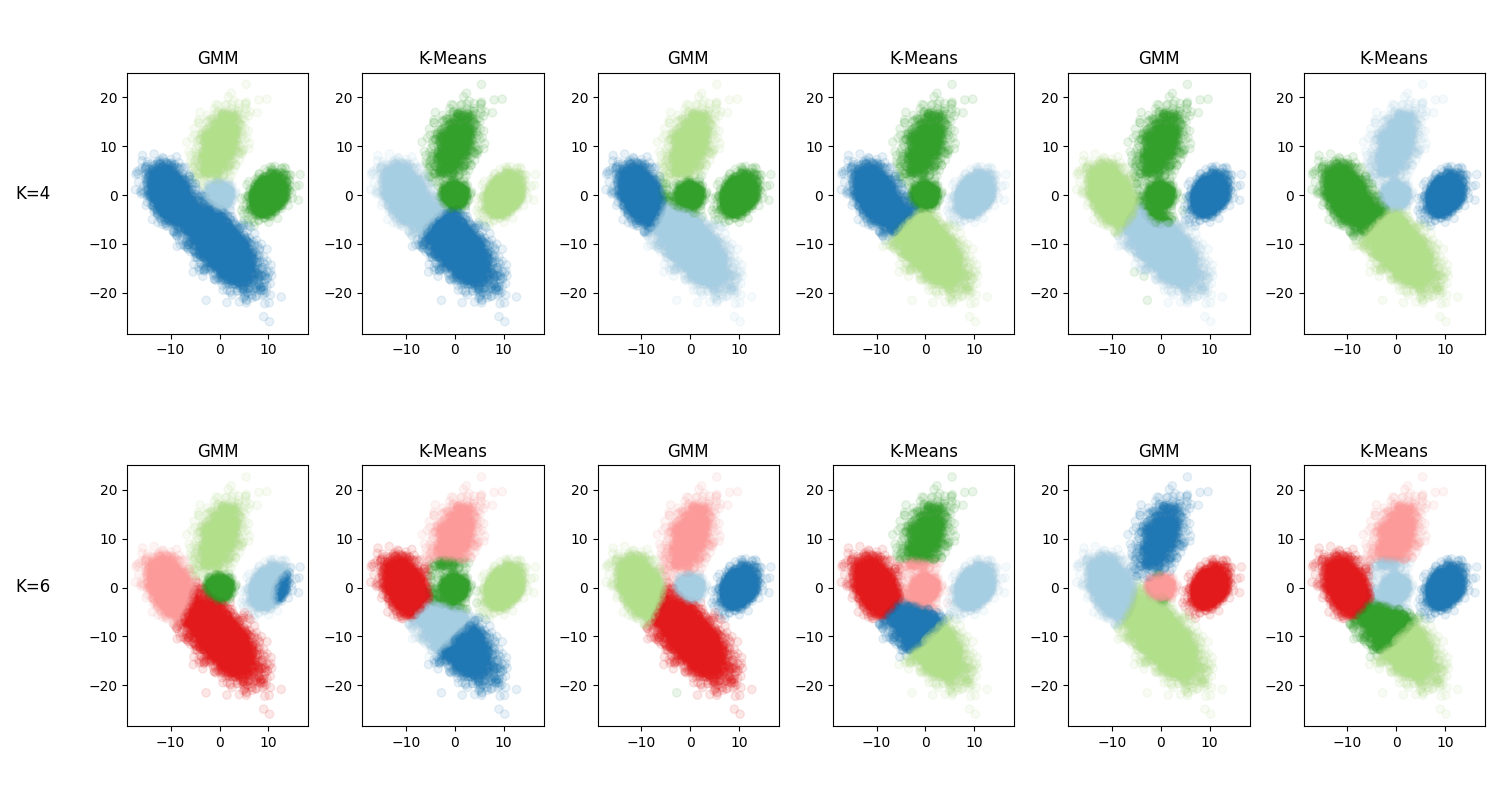

In [70]:
num_repeats = 3  # Number of times to repeat the fitting
cluster_values = [4, 6]  # Number of clusters to try (K=4 and K=6)

# Prepare a grid for the plots: rows for K, columns for GMM and K-Means per run
fig, axes = plt.subplots(len(cluster_values), num_repeats * 2, figsize=(15, 8))

for i, K in enumerate(cluster_values):  
    for j in range(num_repeats):
        # GMM fitting
        gmm_model = gmm_fit(toy_gmm["X"], K)
        W = gmm_e(toy_gmm["X"], gmm_model)
        gmm_labels = np.argmax(W, axis=1)  # Most likely component for each point
        
        # Plot GMM results
        ax_gmm = axes[i, j * 2]
        ax_gmm.set_title(f"GMM")
        plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], gmm_labels, alpha=0.1, axis=ax_gmm)

        # K-Means fitting
        kmeans_model = KMeans(K, random_state=j).fit(toy_gmm["X"])
        kmeans_labels = kmeans_model.labels_
        
        # Plot K-Means results
        ax_kmeans = axes[i, j * 2 + 1]
        ax_kmeans.set_title(f"K-Means")
        plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans_labels, alpha=0.1, axis=ax_kmeans)

# Add row labels for clarity
for i, K in enumerate(cluster_values):
    axes[i, 0].set_ylabel(f"K={K}", fontsize=12, rotation=0, labelpad=40)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


## 2f) Discover the Secret (optional)

In [71]:
# Load the secret data.
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")

In [72]:
# How many components are hidden in this data?